In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from file_cache import *
from fastai.vision import *
from fastai.callbacks.hooks import *

gc.collect()
def unet_learner( arch:Callable, pretrained:bool=False, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None,
                 n_classes=2, img_size = (224,224), in_channels = 1,
                 **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    "blur: do maxpolling or not"
    body = create_body(arch, pretrained, cut)
    model = to_device(models.unet.DynamicUnet(body, n_classes=n_classes, img_size=img_size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), 'cuda')
    #print(model.layers[0][0])
    #out_channels = model.layers[0][0].out_channels 
    #model.layers[0][0] = nn.Conv2d(in_channels, out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()
    #model.layers[0][0].in_channels = 1
    return model

#model = unet_learner( models.resnet50, n_classes=2, img_size = (224,224) )
#model(torch.rand(10,3,224,224).cuda()).shape
#model(torch.rand(10,3,224,224).cuda()).shape

2020-05-22 23:58:04,414 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/brain_seg/


In [2]:
from torchvision import transforms
from torchvision import transforms as TF
class DataSet_brain(Dataset):

    def __init__(self, ds_type='train'):
        self.image_size = 256
        self.ds_type = ds_type
        
        df = self.get_df()

        if ds_type == 'train':
            print('========', ds_type)
            print(df.valid.value_counts())
            self.df = df.loc[df.valid == False]
        elif ds_type == 'valid':
            self.df = df.loc[df.valid == True]

#         self.transforms = transforms.Compose([transforms.ToTensor(),
#                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                       transforms.Resize(224)
#                      ])

    def transform(self, image, mask):
        #print(image.shape, mask.shape)
        # Resize
        resize_img = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
                                         transforms.ToPILImage(),
                                         transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                    ])
        
        resize_label = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((224,224)),
                                 
                            ])
        image = resize_img(image)
        mask = resize_label(mask)
        mask = np.array(mask).astype(int)

        return np.array(image), np.where(mask>0, 1, 0)

    def get_p_cnt(self, file):
        label = nib.load(file).get_fdata()
        label = np.where(label>0, 1, 0)
        label = label.sum(axis=0).sum(axis=0)
        return label

    @lru_cache()
    def get_df(self):
        root = '/share/data2/body/brain/NPH_PROCESSED'
        file_list = glob(f'{root}/iNPH_MRI_PROCESSED/*/*.nii.gz')
        df_list = []
        file_list = [file for file in file_list if ' ' not in os.path.basename(file)]
        #print(len(file_list))
        for file in file_list:
            label_cnt = self.get_p_cnt(file)
            # print(os.path.dirname(file))
            fold = [fold for fold in glob(f'{os.path.dirname(file)}/*') if os.path.isdir(fold)][0]
            for dcm_file in glob(f'{fold}/*'): 
                slice_sn = int(dcm_file.split('_')[-1].split('.')[0])-1
                df_list.append({'input_path' :  dcm_file, 
                                'label_path' : file, 
                                'slice_sn' : slice_sn,
                                'p_cnt' : label_cnt[slice_sn],
                               })
            # print(glob(f'{file}/*_Processed.nii.gz')[0])
        df = pd.DataFrame(df_list)
        df = df.sample(frac=1, random_state=2020)
        df['p_id'] = df.label_path.rank()
        df['valid'] = df.input_path.rank() <= len(df)/5
        df = df.loc[df.p_cnt>0] 
        return df

    def __getitem__(self, index):
        img = self.df.input_path.iloc[index]
        #print(img)
        img = pydicom.dcmread(img, force=True).pixel_array.astype(np.int32)
        img = (img-img.min())/(img.max()-img.min())
        
        slice_sn = self.df.slice_sn.iloc[index]-1
        #print(slice_sn)
   
        label = self.df.label_path.iloc[index]
        #print(label)
        label = nib.load(label).get_fdata()
        label = label[:,:,slice_sn].T
        
        #print(img.dtype, label.dtype)
        #return img, label
        return self.transform(img.astype(np.float32), label.astype(np.uint8)) 

    def __len__(self):
        return len(self.df)

    
for sn, (a, b) in enumerate(DataSet_brain()):
    print('===',type(a), type(b), a.shape, b.shape, np.unique(b))
    if sn> 2: break
    

# df = DataSet_brain().get_df()#.shape
# df.sort_values('label_path').shape


======== train
False    442
True     110
Name: valid, dtype: int64
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1]


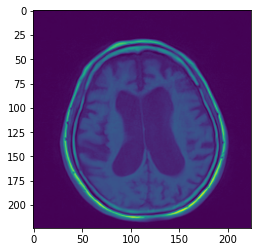

In [3]:
plt.imshow(a[0])

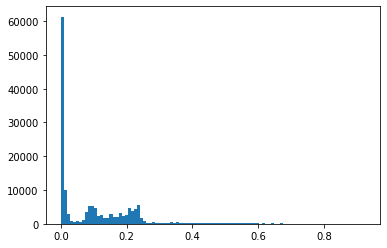

In [4]:
plt.hist(np.array(a).flatten(), bins=100)
plt.show()

(array([0, 1]), array([46303,  3873]))

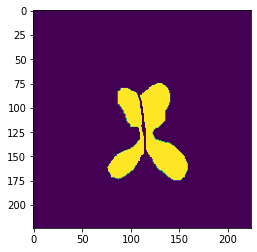

In [5]:
plt.imshow(b*40)
np.unique(b, return_counts=True)

In [6]:
def dice(logits, targets, class_index=None):
    #print('======', logits.shape,  targets.shape)
    if class_index is not None:
        class_list = [class_index]
    else:
        class_list = range(2)
    dice_list = edict()    
    for class_index in class_list:
        predict = torch.Tensor(np.where(a.argmax(axis=1)==class_index, 1, 0))
        target  = torch.Tensor(np.where(targets==class_index, 1, 0))
        
        
        #print('======', predict.shape,  target.shape)
        #print(predict.shape, logits.shape, target.shape)
        inter = torch.sum(predict * target)
        union = torch.sum(predict) + torch.sum(target)
        dice = (2. * inter + 1) / (union + 1)
        #print(dice, inter, union)
        dice_list[str(class_index)] = np.round(float(dice), 4)
    print(dice_list)
    return np.array(list(dice_list.values()) ).mean() #dice_list.values().mean()


a = torch.Tensor(np.random.rand(2, 5, 224, 224))
b = torch.Tensor(np.random.randint(0,5, (2, 224, 224)))

tmp  = dice(a, b )
tmp

{'0': 0.2008, '1': 0.1959}


0.19835

In [7]:
#model = unet_learner( models.resnet50, n_classes=5, img_size = (224,224) ) 

In [ ]:
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

class BrainModel(pl.LightningModule):

    def __init__(self, model=None):
        super(BrainModel, self).__init__()
        self.unet =  unet_learner( models.resnet50, n_classes=2, img_size = (224,224) ) 
        self.weight = torch.tensor([0.5, 1]).cuda()

    def forward(self, x):
        # called with self(x)
        #print(x.shape)
        return self.unet(x)

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        #print(y_hat.shape, y.shape, loss)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y, weight=self.weight ), 'dice': dice(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        import ipdb
        #ipdb.set_trace()
        dice = np.stack([x['dice'] for x in outputs]).mean()
        dice = round(dice, 4)
        tensorboard_logs = {'val_loss': avg_loss, 'dice':dice}
        print({'val_loss': avg_loss, 'dice':dice})
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        print('test_step')
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y, weight=self.weight)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.0002)

    def train_dataloader(self):
        # REQUIRED
        return DataLoader(DataSet_brain('train'), batch_size=2, )
        #return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(DataSet_brain('valid'), batch_size=2, )
        ##return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(DataSet_brain('valid'), batch_size=2,  )
        #return DataLoader(MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor()), batch_size=32)
        
        
brain_model = BrainModel( )

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1,
                     weights_summary=None)    
trainer.fit(brain_model)  



2020-05-22 23:58:31,663 distrib_data_parallel.py[220] INFO GPU available: True, used: True
2020-05-22 23:58:31,665 distrib_data_parallel.py[268] INFO VISIBLE GPUS: 0


{'0': 0.3308, '1': 0.0674}
{'0': 0.3319, '1': 0.0446}
{'0': 0.3329, '1': 0.005}
{'0': 0.3312, '1': 0.0578}
{'0': 0.3325, '1': 0.0095}
{'val_loss': tensor(11.1027, device='cuda:0'), 'dice': 0.1844}


======== train
False    442
True     110
Name: valid, dtype: int64


{'0': 0.3308, '1': 0.0674}
{'0': 0.3319, '1': 0.0446}
{'0': 0.3329, '1': 0.005}
{'0': 0.3312, '1': 0.0578}
{'0': 0.3325, '1': 0.0095}
{'0': 0.3315, '1': 0.0563}
{'0': 0.3325, '1': 0.0165}
{'0': 0.3309, '1': 0.0552}
{'0': 0.331, '1': 0.0728}
{'0': 0.3301, '1': 0.0719}
{'0': 0.3317, '1': 0.0421}
{'0': 0.332, '1': 0.0208}
{'0': 0.3318, '1': 0.0399}
{'0': 0.3306, '1': 0.0605}
{'0': 0.3321, '1': 0.0239}
{'0': 0.3313, '1': 0.0521}
{'0': 0.3305, '1': 0.0718}
{'0': 0.3312, '1': 0.0511}
{'0': 0.3309, '1': 0.0586}
{'0': 0.3328, '1': 0.0107}
{'0': 0.3312, '1': 0.0586}
{'0': 0.3304, '1': 0.0612}
{'0': 0.3287, '1': 0.108}
{'0': 0.3306, '1': 0.0828}
{'0': 0.3315, '1': 0.0423}
{'0': 0.3327, '1': 0.0075}
{'0': 0.333, '1': 0.002}
{'0': 0.3321, '1': 0.0327}
{'0': 0.3326, '1': 0.0117}
{'0': 0.3324, '1': 0.0203}
{'0': 0.3332, '1': 0.0033}
{'0': 0.33, '1': 0.0799}
{'0': 0.3281, '1': 0.1115}
{'0': 0.3313, '1': 0.0531}
{'0': 0.3324, '1': 0.03}
{'0': 0.3322, '1': 0.0309}
{'0': 0.3308, '1': 0.0502}
{'0': 0.331

{'0': 0.3308, '1': 0.0674}
{'0': 0.3319, '1': 0.0446}
{'0': 0.3329, '1': 0.005}
{'0': 0.3312, '1': 0.0578}
{'0': 0.3325, '1': 0.0095}
{'0': 0.3315, '1': 0.0563}
{'0': 0.3325, '1': 0.0165}
{'0': 0.3309, '1': 0.0552}
{'0': 0.331, '1': 0.0728}
{'0': 0.3301, '1': 0.0719}
{'0': 0.3317, '1': 0.0421}
{'0': 0.332, '1': 0.0208}
{'0': 0.3318, '1': 0.0399}
{'0': 0.3306, '1': 0.0605}
{'0': 0.3321, '1': 0.0239}
{'0': 0.3313, '1': 0.0521}
{'0': 0.3305, '1': 0.0718}
{'0': 0.3312, '1': 0.0511}
{'0': 0.3309, '1': 0.0586}
{'0': 0.3328, '1': 0.0107}
{'0': 0.3312, '1': 0.0586}
{'0': 0.3304, '1': 0.0612}
{'0': 0.3287, '1': 0.108}
{'0': 0.3306, '1': 0.0828}
{'0': 0.3315, '1': 0.0423}
{'0': 0.3327, '1': 0.0075}
{'0': 0.333, '1': 0.002}
{'0': 0.3321, '1': 0.0327}
{'0': 0.3326, '1': 0.0117}
{'0': 0.3324, '1': 0.0203}
{'0': 0.3332, '1': 0.0033}
{'0': 0.33, '1': 0.0799}
{'0': 0.3281, '1': 0.1115}
{'0': 0.3313, '1': 0.0531}
{'0': 0.3324, '1': 0.03}
{'0': 0.3322, '1': 0.0309}
{'0': 0.3308, '1': 0.0502}
{'0': 0.331